# ELECTRA BASE alternative for Disaster Tweets

In this project I will use ELECTRA - Base to classify disaster tweets. I will use the dataset of this [Kaggle Contest](https://www.kaggle.com/c/nlp-getting-started/overview).

## Common Imports

We need basic requirements including torch, pandas, and wordcloud.

In [1]:
!pip install pandas tqdm
!pip install wordcloud
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
  Using cached https://download.pytorch.org/whl/cu118/torch-2.2.2%2Bcu118-cp310-cp310-linux_x86_64.whl (819.2 MB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cuda_nvrtc_cu11-11.8.89-py3-none-manylinux1_x86_64.whl (23.2 MB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cuda_runtime_cu11-11.8.89-py3-none-manylinux1_x86_64.whl (875 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 102.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

## Connecting to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Verifying if the conection was succesfull.

In [3]:
!ls
!pwd

drive  sample_data
/content


Important Note: You need to create the structure of the repository in our Drive to avoid errors.

## Importing base libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import torch
from transformers import ElectraTokenizer, ElectraForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from tqdm import tqdm
import time
import torch
import numpy as np
from wordcloud import WordCloud
import json

from collections import deque
sns.set()

Verifying cuda is available.

In [5]:
torch.cuda.is_available()

True

## Dataset Analysis

### Importing the dataset from source

In [6]:
PATH_REPO = "/content/drive/MyDrive/Repos/Natural-Language-Processing-with-Disaster-Tweets-with-ELECTRA"

In [7]:
df = pd.read_csv(f'{PATH_REPO}/data/train.csv')
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [8]:
test_df = pd.read_csv(f'{PATH_REPO}/data/test.csv')
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


### Filtering to-use columns

In [9]:
df = df[['text', 'target']]
df

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


### Wordcloud of Non-Processed Text

Both word clouds are nearly identical because we decided not to preprocess using libraries such as NLTK. We only filtered punctuation and converted the text to lowercase.

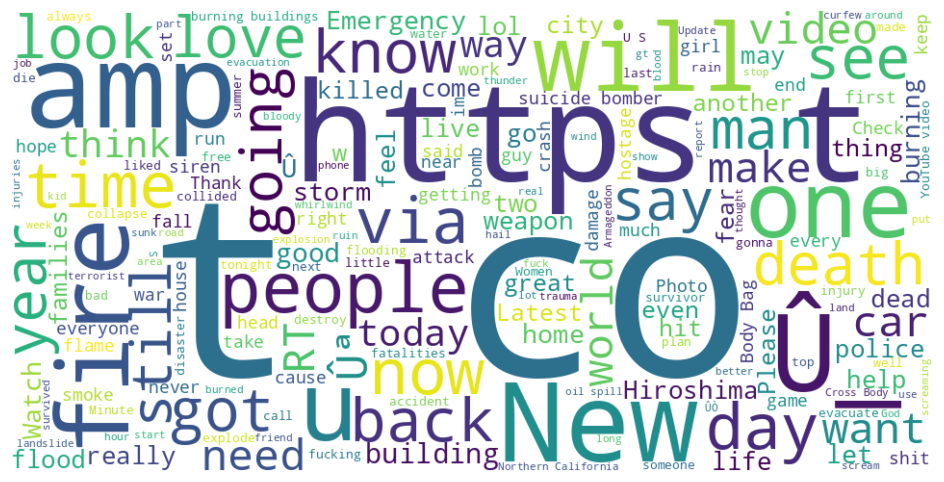

In [10]:
plt.figure(figsize=(12, 6))

text = " ".join(list(df['text']))

wordcloud = WordCloud(width=960, height=480, background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')


plt.savefig(f'{PATH_REPO}/figures/Wordcloud_of_not_processed_text.png')
plt.show()

In [11]:
word_count = df['text'].apply(lambda x: len(list(x.split())))
print("Max word count in crude texts:", max(word_count))

Max word count in crude texts: 31


### Word Count Distribution Histogram

The plot shows that most of the text falls within the 1-100 word count range, which is perfect for our model with a maximum of 128 tokens.

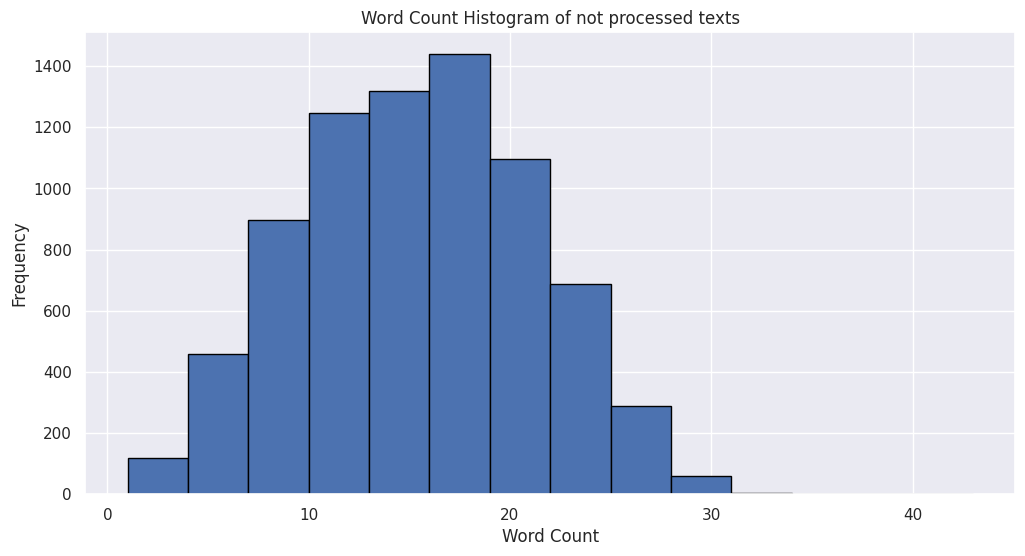

In [12]:
plt.figure(figsize=(12, 6))

plt.hist(word_count, bins=range(min(word_count), max(word_count) + 15, 3), edgecolor='black')

plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Histogram of not processed texts')
plt.savefig(f'{PATH_REPO}/figures/Histogram_Word_count_not_processed.png')
plt.show()

### Label Distribution

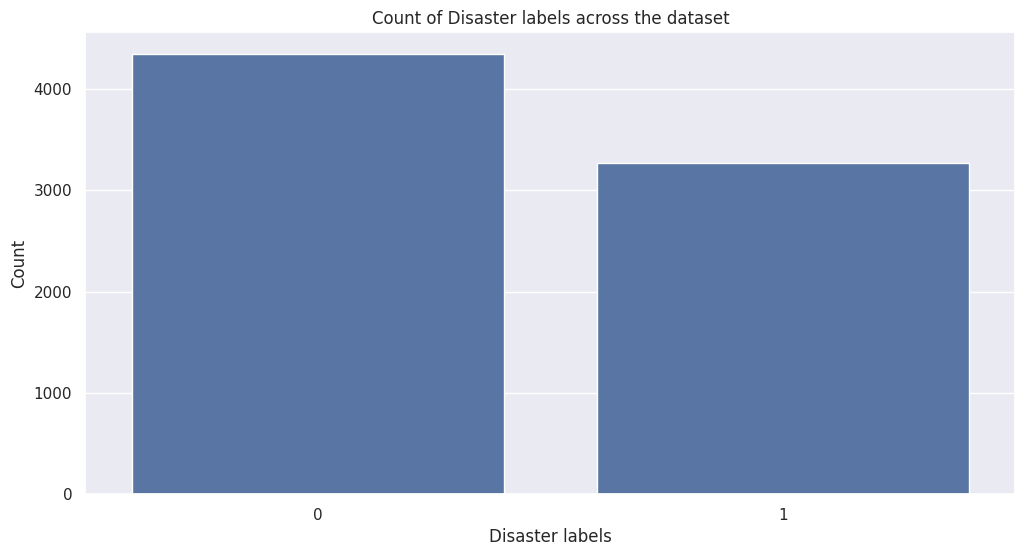

In [34]:
plt.figure(figsize=(12, 6))
sns.countplot(x='target', data=df)
plt.xlabel("Disaster labels")
plt.ylabel("Count")
plt.title("Count of Disaster labels across the dataset")
plt.savefig(f'{PATH_REPO}/figures/Count_of_disaster_labels_across_the_dataset.png')
plt.show()


### Target labeling to numeric

In [14]:
df.dtypes

text      object
target     int64
dtype: object

In [15]:
df = df[['text', 'target']]
df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())
df.head()

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,13000 people receive wildfires evacuation orde...,1
4,just got sent this photo from ruby alaska as s...,1


In [16]:
test_df['text'] = test_df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,just happened a terrible car crash
1,2,NaN,NaN,heard about earthquake is different cities sta...
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan


### Wordcloud of Processed Text

As mentioned, due to the preprocessing, there is almost no change in the word distribution of the dataset.

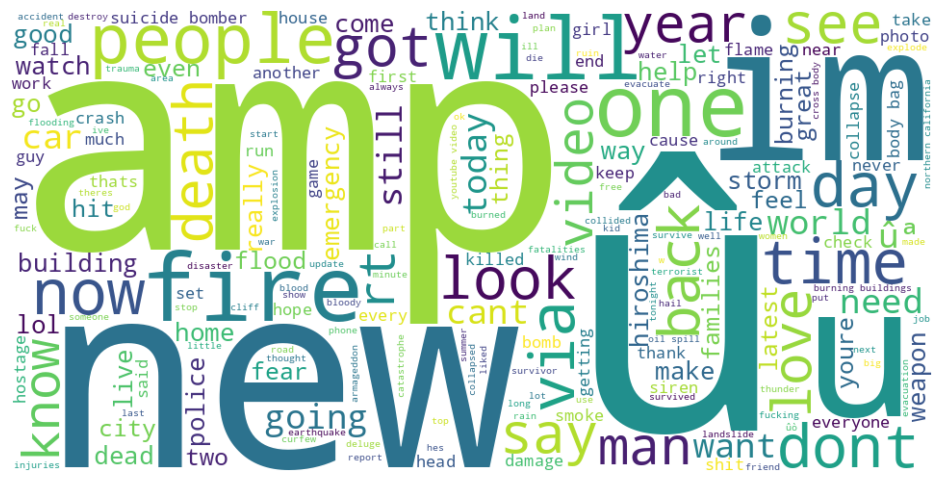

In [17]:
plt.figure(figsize=(12, 6))

text = " ".join(list(df['text']))

wordcloud = WordCloud(width=960, height=480, background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')


plt.savefig(f'{PATH_REPO}/figures/Wordcloud_of_processed_text.png')
plt.show()

In [18]:
word_count = df['text'].apply(lambda x: len(list(x.split())))
print("Max word count in preprocessed texts:", max(word_count))

Max word count in preprocessed texts: 31


### Distribution of Post-Processed Text Histogram

Even though the maximum number of words may change, the word distribution remains almost the same after preprocessing.

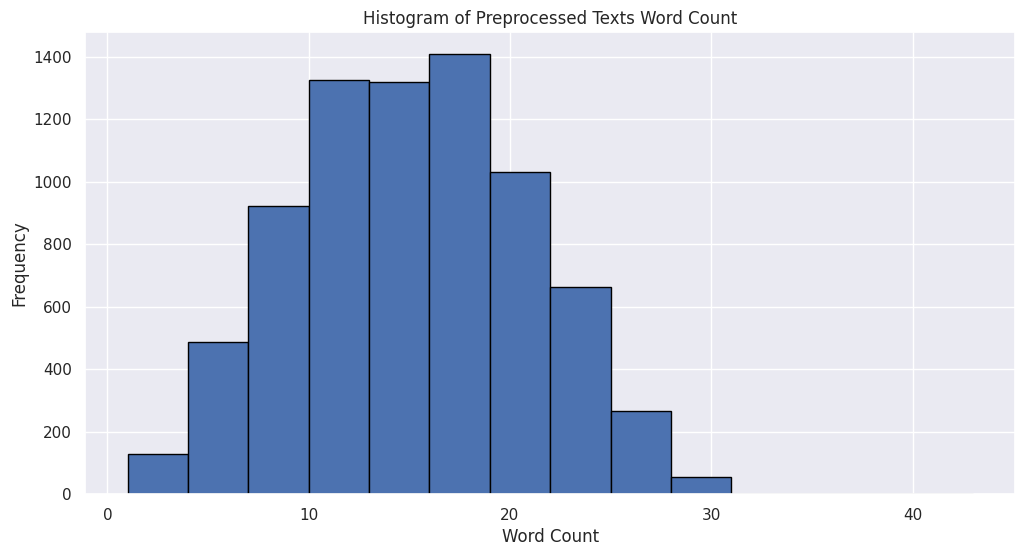

In [19]:
plt.figure(figsize=(12, 6))

plt.hist(word_count, bins=range(min(word_count), max(word_count) + 15, 3), edgecolor='black')

plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Preprocessed Texts Word Count')
plt.savefig(f'{PATH_REPO}/figures/Word_Count_Histogram_Preprocessed_texts.png')
plt.show()

## Model Building

First, we'll separate the data into a training set and a test set, with a split of 70/30%. Then, we'll create some classes for data and model handling.

In [20]:
# df = df.head(10)

In [21]:
X = df[['text']]
y = df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [22]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [23]:
class TransformerModel:
  def __init__(self, tokenizer_class, tokenizer_name, model_class, model_name):
    self.batch_size = 64
    self.max_length = 128
    self.num_epochs = 30
    self.learning_rate = 4e-5
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.tokenizer = tokenizer_class.from_pretrained(tokenizer_name)
    self.model = model_class.from_pretrained(model_name).to(self.device)
    self.optimizer = AdamW(self.model.parameters(), lr=self.learning_rate)


  def create_dataloader(self, texts, labels):
    dataset = CustomDataset(list(texts), list(labels), self.tokenizer, self.max_length)
    return DataLoader(dataset, batch_size=self.batch_size)

  def fit(self, train_loader, valid_loader):
    self.train_loss_list = list()
    self.valid_loss_list = list()
    valid_loss_history = deque(maxlen=3)
    best_score = float('inf')
    best_epoch = 0

    for epoch in range(self.num_epochs):
      ### Training
      self.model.train()
      total_loss = 0
      for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}', leave=False):
          self.optimizer.zero_grad()

          input_ids = batch['input_ids'].to(self.device)
          attention_mask = batch['attention_mask'].to(self.device)
          labels = batch['labels'].to(self.device)

          outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)

          loss = outputs.loss
          total_loss += loss.item()

          loss.backward()
          self.optimizer.step()
      avg_loss = total_loss / len(train_loader)
      print("Training Loss", avg_loss)
      self.train_loss_list.append(avg_loss)
      self.model.save_pretrained(f'{PATH_REPO}/models/old/ebase-disaster-epoch-{epoch + 1}/')

      ### Validation
      self.model.eval()
      total_valid_loss = 0
      with torch.no_grad():
          for batch in  tqdm(valid_loader):
              input_ids = batch['input_ids'].to(self.device)
              attention_mask = batch['attention_mask'].to(self.device)
              labels = batch['labels'].to(self.device)

              outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
              loss = outputs.loss
              total_valid_loss += loss.item()

      avg_valid_loss = total_valid_loss / len(valid_loader)
      if best_score > avg_valid_loss:
          best_score = avg_valid_loss + 0
          self.model.save_pretrained(f'{PATH_REPO}/models/Best_model/')
          best_epoch = epoch + 1
      print("Validation loss", avg_valid_loss)
      self.valid_loss_list.append(avg_valid_loss)

      valid_loss_history.append(avg_valid_loss)

      if len(valid_loss_history) == valid_loss_history.maxlen:
          if all(valid_loss_history[i] < valid_loss_history[i+1] for i in range(len(valid_loss_history) - 1)):
              print("Early stopping: Validation loss no longer decreasing.")
              break
    loss_df = pd.DataFrame()
    loss_df["train_loss"] = self.train_loss_list
    loss_df["valid_loss"] = self.valid_loss_list
    loss_df.to_csv(f'{PATH_REPO}/results/loss_history.csv', index=False)
    print(f'Best epoch: {best_epoch} with score {best_score}')



  def predict(self, texts):
    predictions = []
    for text in tqdm(list(texts)):
        inputs = self.tokenizer(text,
                                return_tensors='pt',
                                max_length=self.max_length,
                                truncation=True,
                                padding='max_length')

        inputs = {key: value.to(self.device) for key, value in inputs.items()}
        outputs = self.model(**inputs)
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=1).item()
        predictions.append(predicted_label)
    return predictions

  def score(self, texts, y):
    preds = self.predict(texts)
    return f1_score(y, preds)

### Model Creation

For this step, we will utilize our previous class "TransformerModel."

In [24]:
ebase = TransformerModel(ElectraTokenizer,
                          'google/electra-base-discriminator',
                          ElectraForSequenceClassification,
                          'google/electra-base-discriminator')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This imple

### Model Training

The parameters used for this training are specified in the base class we created by default. They are as follows:

* Batch size: 64.
* Max Length: 128.
* Number of epochs: 30.
* Learning Rate: 4e-5

In [25]:
print("Creating Dataloader")
dataloader_train = ebase.create_dataloader(X_train['text'], y_train)
dataloader_val = ebase.create_dataloader(X_val['text'], y_val)
print("Training model")
ebase.fit(dataloader_train, dataloader_val)
print("Ending")

Creating Dataloader
Training model


Training Loss 0.46293462923279516


100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Validation loss 0.3995264271895091


Training Loss 0.3501422194143136


100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Validation loss 0.42853811383247375


Training Loss 0.2788163134483276


100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Validation loss 0.447140966852506
Early stopping: Validation loss no longer decreasing.
Best epoch: 1 with score 0.3995264271895091
Ending


### Model Evaluation

For this evaluation, after saving the losses of all epochs, I will plot it in a line plot by epoch.


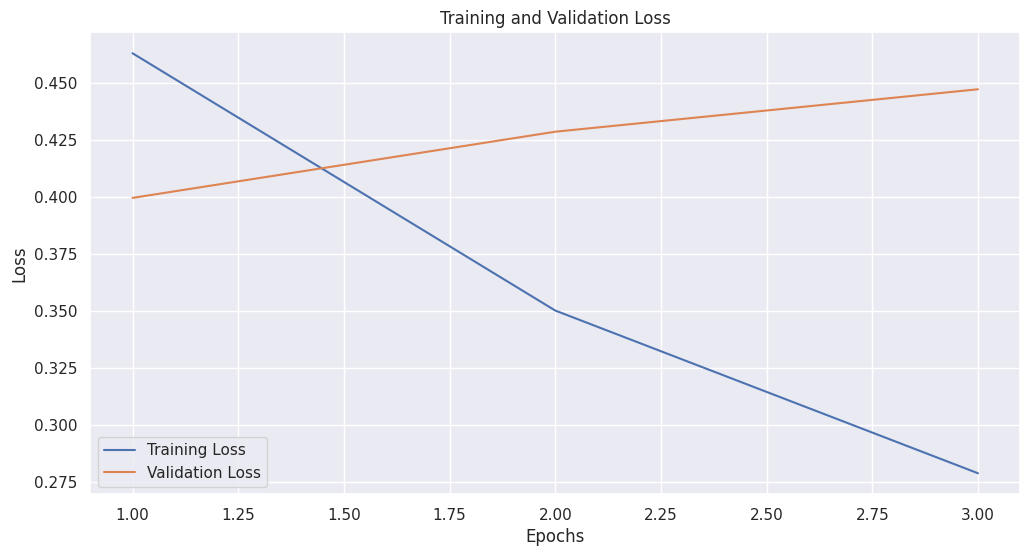

In [26]:
loss_history = pd.read_csv(f'{PATH_REPO}/results/loss_history.csv')

loss_train = list(loss_history['train_loss'])
loss_valid = list(loss_history['valid_loss'])

epochs = range(1, len(loss_train) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_train, label='Training Loss')
plt.plot(epochs, loss_valid, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.grid(True)
plt.savefig(f'{PATH_REPO}/figures/Training and Validation Loss.png')

plt.show()

In [27]:
del ebase

In [31]:
ebase = TransformerModel(ElectraTokenizer,
                          'google/electra-base-discriminator',
                          ElectraForSequenceClassification,
                          'google/electra-base-discriminator')

ebase.model = ElectraForSequenceClassification.from_pretrained(f'{PATH_REPO}/models/Best_model/').to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
test_df['target'] = ebase.predict(test_df['text'])
test_df

100%|██████████| 3263/3263 [01:00<00:00, 54.08it/s]


,id,keyword,location,text,target
0,0,NaN,NaN,just happened a terrible car crash,1
1,2,NaN,NaN,heard about earthquake is different cities sta...,1
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...,1
3,9,NaN,NaN,apocalypse lighting spokane wildfires,1
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles ûò safety faste...,1
3259,10865,NaN,NaN,storm in ri worse than last hurricane my citya...,1
3260,10868,NaN,NaN,green line derailment in chicago httptcoutbxlc...,1
3261,10874,NaN,NaN,meg issues hazardous weather outlook hwo httpt...,1


In [35]:
test_df['target'].value_counts()

target
0    1915
1    1348
Name: count, dtype: int64

In [36]:
ans_df = test_df[['id', 'target']]
ans_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [37]:
ans_df.to_csv(f'{PATH_REPO}/data/answer.csv', index=False)

## Conclusions and Future Work

I achieved 0.82 in evaluation score of the contest and get the 281 place in the leaderboard. In future works, It is possible to improve the performance reducing the batch size, and testing other models such as BERT, DistilBERT, RoBERTa, etc.

In [38]:
"Thats all folks"

'Thats all folks'